# Anomalies
### Authors

Fletcher Hozven fhozven@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import reqquired packages](#import)

[Open the Net CDF File and Print data](#open)

[Choose the variable from our data and Convert Datetime](#tas)

[Define Specfic Region](#Region)

[Spatial average over the selected region](#spatial)

[Calculate the Baseline for Anomalies](#base)

[Compute the Monthly Average](#group)

[Calculate Anomalies](#anomaly)

[Plot the Anomalies!](#plot)

<a id='purpose'></a> 
## **Goals**

For this tutorial, we are going to calculate the anomalies of our desired climate data variable and plot them! Anomalies are frequently used in climate science, and it is crucial to understand what an anomaly is when analyzing your climate data.

_What is an Anomaly ?_

In climate science, an "anomaly" refers to the deviation of a measured climate variable (like temperature or precipitation) from its long-term average value for a specific location and time period. An anomaly shows how much a measurement differs from what is considered "normal" for that area. A positive anomaly indicates a value higher than the average, while a negative anomaly indicates a value lower than the average. 

_How to calculate an Anomaly ?_

Simply an anomaly is the difference between an actual value and some long-term average value.

For example if ...
- X = actual value of average temperature for January, 1982 
- Xbar = long-term average temperature for January (an average over many years)
- anom = anomaly value for January, 1982

Then the anom = X - Xbar

Example of an Anomaly Plot from [NOAA](https://www.ncei.noaa.gov/news/noaa-updates-its-global-surface-temperature-dataset)
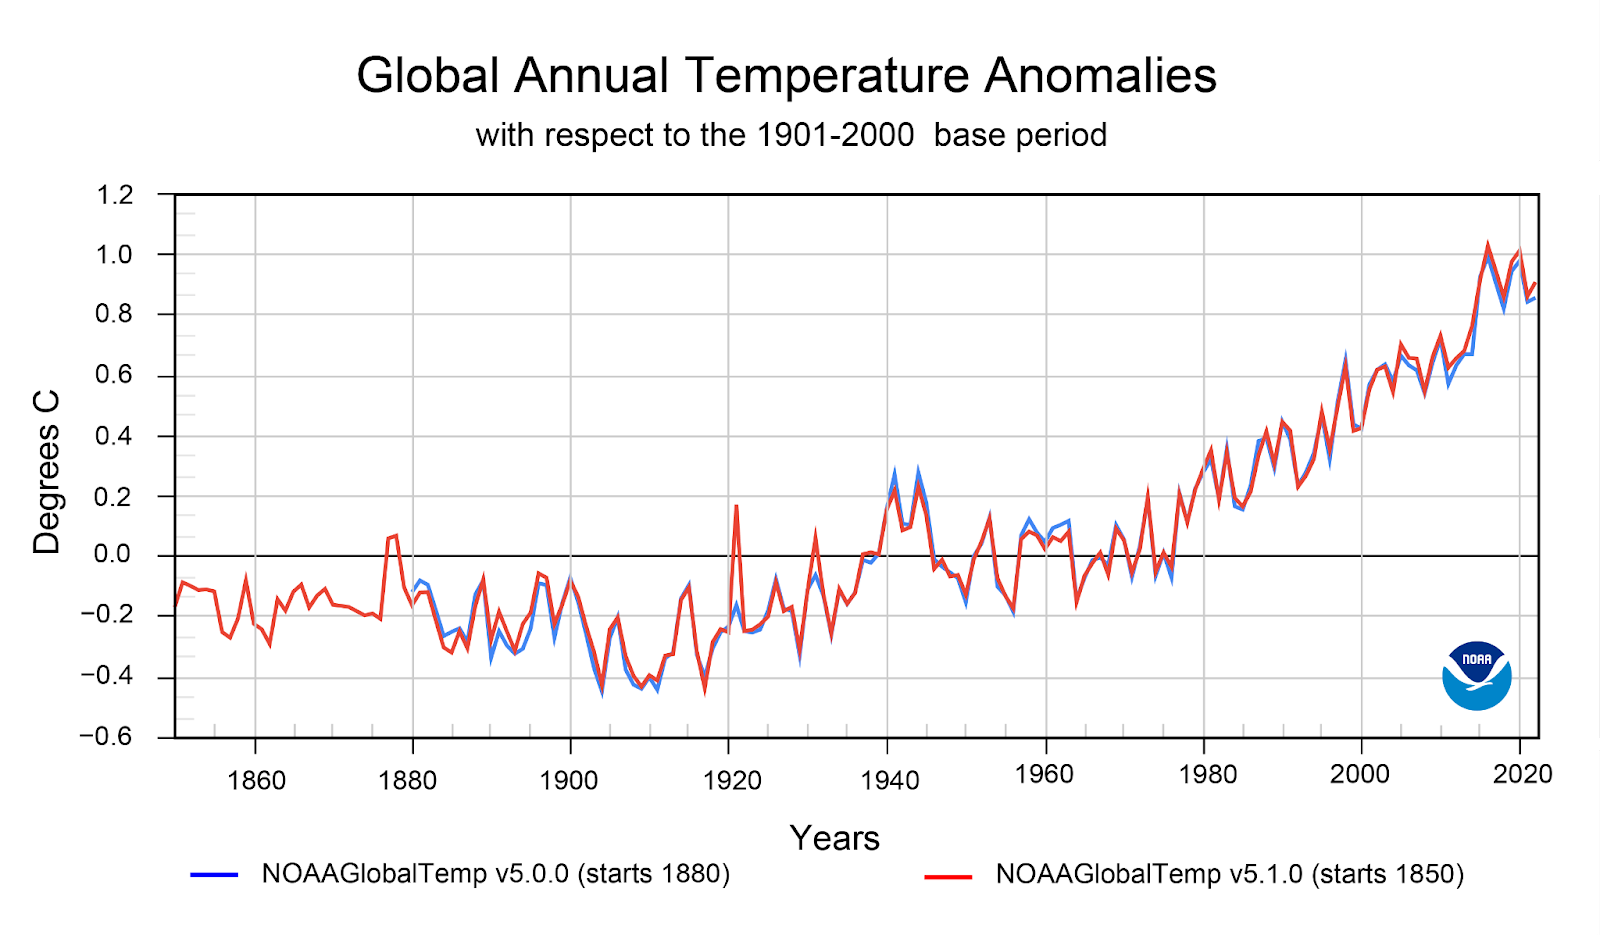

<a id='Import'></a> 
## **Import Required Packages**

In [306]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

<a id='Path'></a> 
## **Open the Net CDF File and Print data**

In [308]:
data = xr.open_dataset('/Users/fletcherhoz/Desktop/tas_Amon_BCC-CSM2-MR_amip-future4K_r1i1p1f1_gn_197901-201412.nc')
data

<xarray.Dataset>
Dimensions:    (time: 432, bnds: 2, lat: 160, lon: 320)
Coordinates:
  * time       (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CFMIP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                The experiment, where SSTs are subject to a compo...
    ...                     ...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/7102d807-f36f-4590-ab96-918a98caa705
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by Lawrence Livermore B...
    cmor_version:           3.3.2

<a id='tas'></a> 
## **Choose the variable from our data and Convert Datetime**
- `tas` varible is seen above the the data as the varible for near surface air temperature
- Replace `tas` with your chosen variable!
- Set a name for `data.tas` so it is easier to write down later!
- Cnverting the time using `.astype` to datetime64 will be a simple function shown below.

In [310]:
tas = data.tas
time= data.time.astype('datetime64[ns]')

<a id='Region'></a> 
## **Define Specfic Region** 
__Lets choose New York City like our previous tutorial__

A) Define the latitude and longitude bounds for New York City¶
- This code snippet is setting up two pairs of variables, `lat_min` and `lat_max` for latitude, and `lon_min` and `lon_max` for longitude.
- These variables are used to define a specific geographic region of interest within a broader dataset
- You can use a map or a globe to determine the approximate latitude and longitude boundaries of the region you're interested in.

In [312]:
lat_min, lat_max = 40.5, 41
lon_min, lon_max = 286, 287

B) Subset the Data for New York City
- The code defines latitude and longitude masks for New York City using the `tas` dataset.
- The masks (`tas_NYC_lat` and `tas_NYC_lon`) filter the dataset to include only the grid cells within the specified latitude (`lat_min` to `lat_max`) and longitude (`lon_min` to `lon_max`) boundaries.
- Finally, the `tas.where()` function is used to subset the data to the specified region, dropping any data points outside the specified latitude and longitude range.

In [314]:
tas_NYC_lat = (tas.lat >= lat_min) & (tas.lat <= lat_max)
tas_NYC_lon = (tas.lon >= lon_min) & (tas.lon <= lon_max)
tas_NYC = tas.where(tas_NYC_lat & tas_NYC_lon, drop=True)

<a id='spatial'></a> 
## **Spatial average over the selected region**

Contains the average temperature for NYC over time, with the latitude and longitude dimensions removed.

_Make sure to do this step before computing the annual mean temperature_

In [316]:
tas_NYC = tas_NYC.mean(dim=['lat','lon'])

- `tas_NYC` filtered temperature data for New York City.
- `.mean(dim=['lat', 'lon'])`Averages the temperature data over all the latitude and longitude points in the NYC region that was set in the pervious step
- The result is a single average temperature value for each time step, rather than multiple values for different locations.
- __Without first averaging the temperature data over the region, the regional average will be miscomputed__
- Because the input values for the regional average should represent a single average point for the entire region, rather than multiple values from various locations. 

<a id='base'></a> 
## **Calculate the Baseline for Anomalies**  

- Select the time period you want to use as the baseline. For mine I am using 1990-2010
- __Make sure your chosen time period is avaible in your climate data!__ You can see this when you print the data
- `.sel` selects a specific varible from your data
- `time=slice()` is a function to slice the desired time from your climate data

Here we have just defined the anaomly __baseline__ which serves as reference points or models that represent the normal behavior of a system or dataset under normal conditions. As said before our baseline will be the years from 1990-2010. 

In [319]:
baseline_sel = tas_NYC.sel(time=slice("1990-01-01", "2010-12-31"))

<a id='group'></a> 
## **Compute the Monthly Average**  
- We compute yearly averages across the baseline period.
- `.groupby` will group your data by a specific paramter which in this case is `time.month` which is grouping the time to be by month
- `.mean` is averaging the time by each month so there is one avergaed value of temperature for each month

In [321]:
baseline = baseline_sel.groupby("time.month").mean("time")
baseline

<xarray.DataArray 'tas' (month: 12)>
array([276.47174, 277.9345 , 279.98688, 285.26617, 290.65042, 297.08197,
       301.44507, 301.93356, 297.96945, 292.00644, 284.79315, 278.8935 ],
      dtype=float32)
Coordinates:
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<a id='Anomaly'></a> 
## **Calculate Anomalies**  
- Subtract the baseline monthly average from the original dataset to get anomalies.
- Our `temp_data` is the orignal data set which represents X
- Our `baseline` is the long-term monthly average over the time period 1990-2010 (30 year average) which represents Xbar
- Our `anomaly` is the value that shows how much each month temperature data differs from what is considered "normal".

In [323]:
anomaly = tas_NYC.groupby("time.month") - baseline
anomaly

<xarray.DataArray 'tas' (time: 432)>
array([-4.099579  , -5.05542   , -0.30984497, -1.3111572 ,  0.5226135 ,
       -0.6741638 , -0.07330322,  0.29779053, -1.3396301 ,  1.0203247 ,
       -1.5777588 ,  0.51052856,  1.9851074 ,  0.18411255,  0.82354736,
       -0.24090576,  0.6905823 ,  0.16369629,  1.694397  ,  0.99295044,
        0.34823608, -1.5622253 , -1.814209  , -1.7393799 , -4.6582336 ,
       -2.026001  , -0.11779785,  0.22341919, -1.8111267 , -1.1338806 ,
        0.02746582,  0.17089844, -1.6712036 , -1.630249  ,  1.5861206 ,
       -1.4024658 ,  2.0090942 , -1.2645569 ,  0.24032593,  0.6958313 ,
        0.19229126, -2.2868347 , -2.2442627 , -0.64315796, -0.268219  ,
       -0.2447815 ,  2.4685974 , -1.2897644 ,  3.1400452 ,  1.0980225 ,
       -2.7058105 , -1.2415466 , -0.2647705 ,  0.54611206, -0.35617065,
       -0.3203125 ,  0.17181396, -0.41085815, -1.6535034 ,  1.4172058 ,
        2.3291016 ,  3.312561  ,  0.20565796, -0.22180176, -3.084381  ,
       -1.4876404 , -1.3912048 , -1.2011108 , -1.179718  , -2.3105469 ,
        2.035614  ,  0.717865  ,  2.1289368 , -2.2166748 ,  0.672699  ,
        2.0439453 ,  1.1949158 , -0.95028687, -1.1912537 ,  0.29589844,
        1.0748596 ,  1.1124878 ,  1.6925049 ,  0.30755615, -1.8596802 ,
       -2.6274414 , -3.1035156 ,  2.7696533 ,  1.4306335 ,  0.26287842,
        0.8521118 ,  0.83099365, -1.2605286 , -1.1467285 ,  3.8166504 ,
       -1.9118958 , -0.8353882 , -4.084503  , -0.8404846 ,  0.90509033,
...
        1.5740051 , -1.2062073 , -0.8409424 , -1.25531   , -2.1142883 ,
       -0.96398926,  1.4147034 ,  1.2833557 ,  1.6760559 ,  1.5941772 ,
        1.3229675 , -2.2071838 ,  1.9835815 ,  1.933136  ,  0.15933228,
       -0.9121399 , -1.7118835 ,  0.06829834,  2.0574036 , -0.7407837 ,
        0.9219971 , -0.49191284,  0.06796265, -0.1065979 ,  0.1138916 ,
        1.7822571 ,  0.6178589 ,  1.8930359 ,  2.0130005 , -0.8016968 ,
       -2.029358  , -0.38812256, -0.40527344,  0.01898193, -0.43865967,
       -0.40792847,  1.65979   , -1.541687  , -0.71307373,  1.7728577 ,
        1.0610962 ,  0.5467529 ,  2.1487122 ,  2.3156738 ,  0.70269775,
        1.4711609 ,  1.0834656 ,  2.4927368 , -0.0111084 ,  0.46090698,
       -3.3764648 ,  0.7998657 , -1.0692139 , -0.2845459 , -0.22421265,
        1.0799255 ,  1.1209106 , -1.0724182 ,  0.403656  ,  3.096466  ,
       -0.2529297 ,  5.971924  ,  3.9961548 ,  4.170227  ,  1.2798462 ,
        3.8114014 ,  2.651184  ,  1.5328674 ,  0.5223999 ,  0.01983643,
        0.15203857,  1.1862793 , -2.2993164 ,  0.19464111, -1.7746277 ,
        2.2648315 , -0.32907104,  1.078186  ,  1.4483032 ,  0.15567017,
        1.5972595 ,  1.159729  , -0.18865967,  0.87942505,  2.1860962 ,
        0.6664734 , -1.2303162 , -1.9212036 , -0.49987793,  1.8405151 ,
       -0.6329651 ,  2.5479126 ,  1.2834167 ,  0.30029297,  0.3234253 ,
        1.2793274 ,  0.45074463], dtype=float32)
Coordinates:
  * time     (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

<a id='Plot'></a> 
## **Plot the Anomalies!**  

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/bf/phdkkb0n5qg1nlhqcqhr_ysw0000gn/T/ipykernel_90702/3877895331.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Anomaly ($\sigma$)")


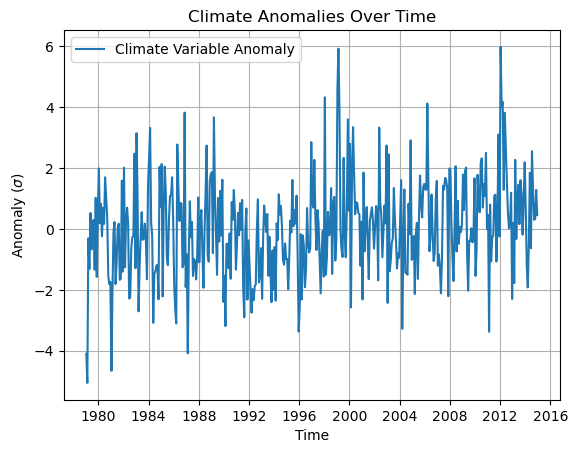

In [325]:
plt.figure()
plt.plot(time, anomaly, label="Climate Variable Anomaly")
plt.xlabel("Time")
plt.ylabel("Anomaly ($\sigma$)")
plt.title("Climate Anomalies Over Time")
plt.legend()
plt.grid()
plt.show()

See how the Plot is centered around zero! This shows that anomaly is plotted correctly. The y axis represntes the standard deviation where 0 is the mean. You can see the temperature anomalies are rising as the standard deviation is increasing !